## Blood cell dataset exploration

In [1]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os
import matplotlib.pyplot as plt
import re
import math

In [2]:
def crop_background(img):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)

    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    return(img[y:y+h,x:x+w])
    

In [3]:
def plot_annotations(imgs_downloaded_folder, img_name, df_cells_coordinates):
    cropped_image = Image.fromarray(crop_background(f"{imgs_downloaded_folder}/{img_name}"))
    df_image_cells = df_cells_coordinates[df_cells_coordinates['img_name']==img_name]
    font_path = "/Library/Fonts/Arial"

    for i in range(len(df_image_cells.index)):
        coords = re.findall(r'\d+', df_image_cells.loc[df_image_cells.index[i], 'bbox'])
        coords = list(map(int,coords))
        label = str(df_image_cells.loc[df_image_cells.index[i], 'class'])
        colors= {"RBC":(255, 0, 0), "WBC":(255,215,0),"Platelets": (0, 0, 255), 'nan':(105,105,105)}

        img = ImageDraw.Draw(cropped_image)
        font = ImageFont.truetype(font_path, 20)

        image = img.rectangle([coords[2], coords[3],  coords[0], coords[1]], outline=colors[label], width=3)
        img.text((coords[0], coords[3]-20),label,colors[label], font=font)


    return cropped_image

In [4]:
imgs_downloaded_folder = "../../new_images"
imgs_downloaded = [f for f in os.listdir(imgs_downloaded_folder) if os.path.splitext(f)[1]=='.jpg']
print("Total images = ", len(imgs_downloaded))

Total images =  364


### Visualize annotations

In [5]:
df_cells_coordinates = pd.read_csv(f"{imgs_downloaded_folder}/cells.csv")
df_cells_coordinates = df_cells_coordinates.fillna("nan").reset_index(drop=True)
df_cells_coordinates.head()

,Unnamed: 0,img_name,class,bbox
0,0,BloodImage_00322.jpg,Platelets,"['168', '374', '198', '406']"
1,1,BloodImage_00322.jpg,Platelets,"['527', '244', '564', '282']"
2,2,BloodImage_00322.jpg,Platelets,"['565', '383', '602', '421']"
3,3,BloodImage_00322.jpg,WBC,"['307', '174', '528', '387']"
4,4,BloodImage_00377.jpg,RBC,"['448', '244', '566', '350']"


Plot annotations on image

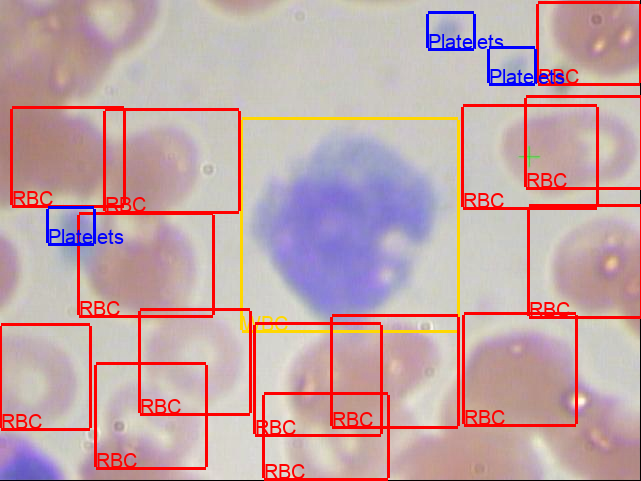

In [6]:
plot_annotations(imgs_downloaded_folder, "BloodImage_00040.jpg", df_cells_coordinates)

#### Count number of cells for each image and class

In [7]:
df_cells_count = df_cells_coordinates.groupby(["img_name", "class"]).size().unstack().reset_index() 
df_cells_count['total_cells'] = df_cells_count[["FBC","Platelets","RBC","WBC", "nan"]].sum(axis=1)

min_n_cells = df_cells_count['total_cells'].min()
max_n_cells = df_cells_count['total_cells'].max()
mean_n_cells = df_cells_count['total_cells'].mean()

print("Min number of cells: ", min_n_cells, "\nimages = ", list(df_cells_count[df_cells_count['total_cells']==min_n_cells]["img_name"]))
print("\nMean number of cells = ", mean_n_cells)
print("\nMax number of cells = ", max_n_cells, "\nimages = ", list(df_cells_count[df_cells_count['total_cells']==max_n_cells]["img_name"]))
print("\n")
df_cells_count


Min number of cells:  1.0 
images =  ['BloodImage_00152.jpg', 'BloodImage_00250.jpg', 'BloodImage_00268.jpg', 'BloodImage_00303.jpg', 'BloodImage_00330.jpg', 'BloodImage_00350.jpg']

Mean number of cells =  13.428571428571429

Max number of cells =  30.0 
images =  ['BloodImage_00037.jpg']




class,img_name,FBC,Platelets,RBC,WBC,nan,total_cells
0,BloodImage_00000.jpg,NaN,NaN,19.0,1.0,NaN,20.0
1,BloodImage_00001.jpg,NaN,NaN,16.0,1.0,2.0,19.0
2,BloodImage_00002.jpg,NaN,NaN,13.0,1.0,2.0,16.0
3,BloodImage_00003.jpg,NaN,1.0,14.0,1.0,1.0,17.0
4,BloodImage_00004.jpg,NaN,1.0,10.0,1.0,1.0,13.0
...,...,...,...,...,...,...,...
359,BloodImage_00405.jpg,NaN,NaN,11.0,1.0,3.0,15.0
360,BloodImage_00407.jpg,NaN,3.0,12.0,1.0,3.0,19.0
361,BloodImage_00408.jpg,NaN,2.0,14.0,1.0,1.0,18.0
362,BloodImage_00409.jpg,NaN,4.0,13.0,1.0,1.0,19.0


In [8]:
pd.DataFrame(df_cells_count.sum().reset_index(), df_cells_coordinates)

,class,0
"(0, BloodImage_00322.jpg, Platelets, ['168', '374', '198', '406'])",NaN,NaN
"(1, BloodImage_00322.jpg, Platelets, ['527', '244', '564', '282'])",NaN,NaN
"(2, BloodImage_00322.jpg, Platelets, ['565', '383', '602', '421'])",NaN,NaN
"(3, BloodImage_00322.jpg, WBC, ['307', '174', '528', '387'])",NaN,NaN
"(4, BloodImage_00377.jpg, RBC, ['448', '244', '566', '350'])",NaN,NaN
...,...,...
"(4883, BloodImage_00396.jpg, FBC, ['16', '174', '118', '277'])",NaN,NaN
"(4884, BloodImage_00396.jpg, RBC, ['539', '402', '640', '480'])",NaN,NaN
"(4885, BloodImage_00396.jpg, Platelets, ['437', '426', '492', '479'])",NaN,NaN
"(4886, BloodImage_00396.jpg, Platelets, ['302', '400', '337', '423'])",NaN,NaN


Image with lowest number of total cells:

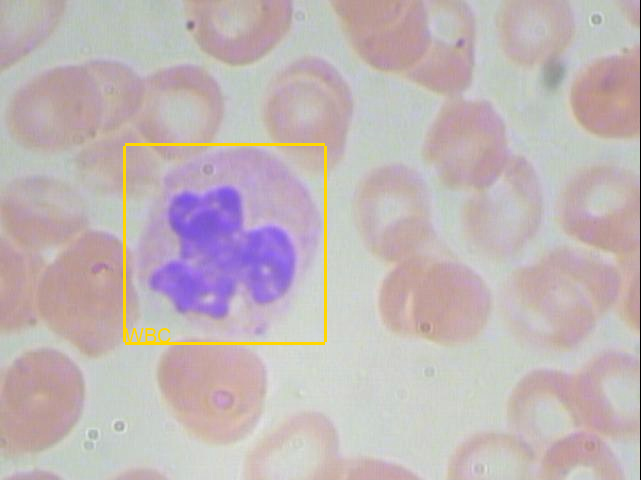

In [9]:
plot_annotations(imgs_downloaded_folder, "BloodImage_00250.jpg", df_cells_coordinates) 

Image with highest number of total cells:

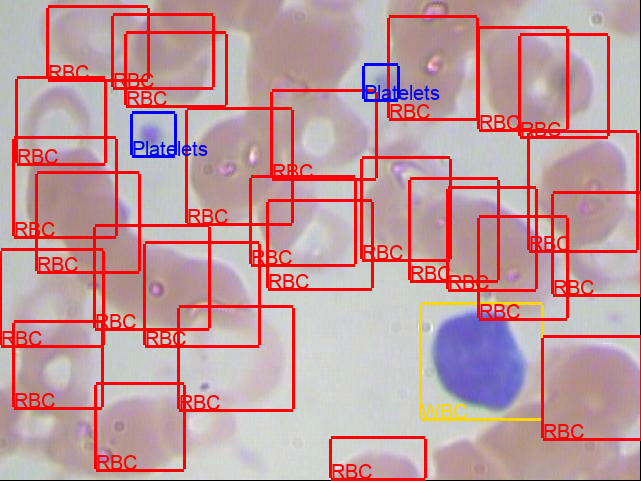

In [10]:
plot_annotations(imgs_downloaded_folder, 'BloodImage_00037.jpg', df_cells_coordinates)

### Plot total cell distribution

<AxesSubplot:>

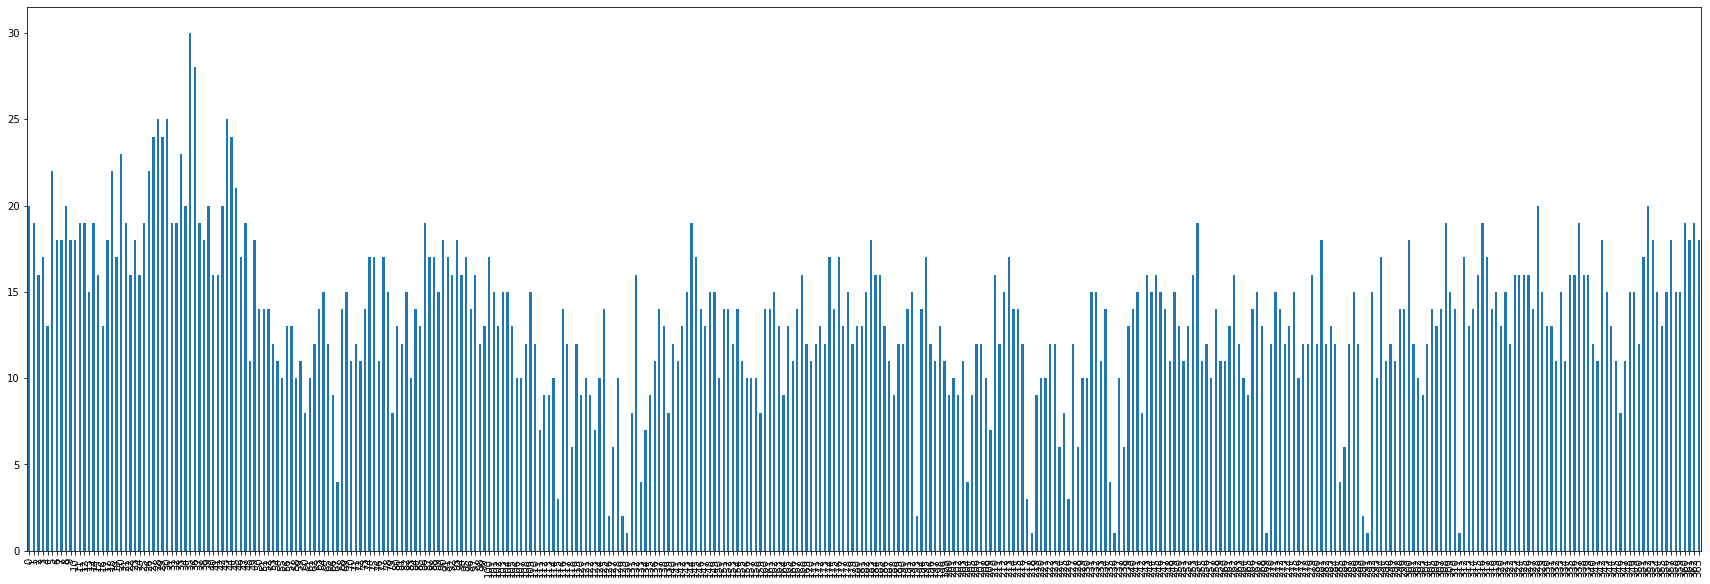

In [11]:
df_cells_count['total_cells'].plot(kind='bar',figsize = (30,10))


### Plot cell distribution by cell type

<AxesSubplot:title={'center':'count'}, xlabel='class'>

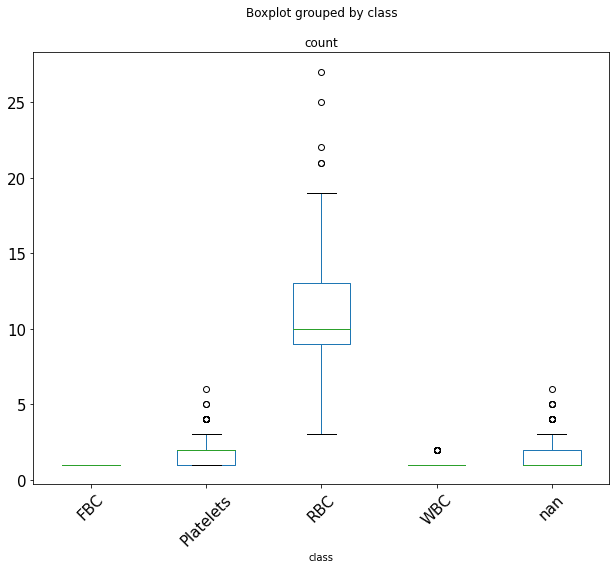

In [12]:
df_cells_coordinates.groupby(["class", "img_name"]).count().rename({"Unnamed: 0":'count'}, axis=1).boxplot('count', by='class', grid=False, rot=45, fontsize=15, figsize=(10,8))
